Model accuracy: 0.8258373205741627
ROC-AUC Score: 0.8247994838633997
Confusion Matrix:
[[400 108]
 [ 74 463]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.79      0.81       508
         1.0       0.81      0.86      0.84       537

    accuracy                           0.83      1045
   macro avg       0.83      0.82      0.83      1045
weighted avg       0.83      0.83      0.83      1045

Predictions saved to 'xgboost_predictions.csv'.


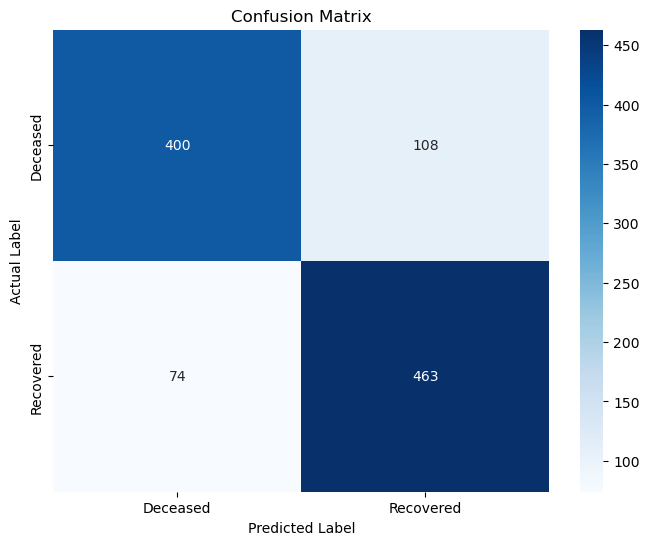

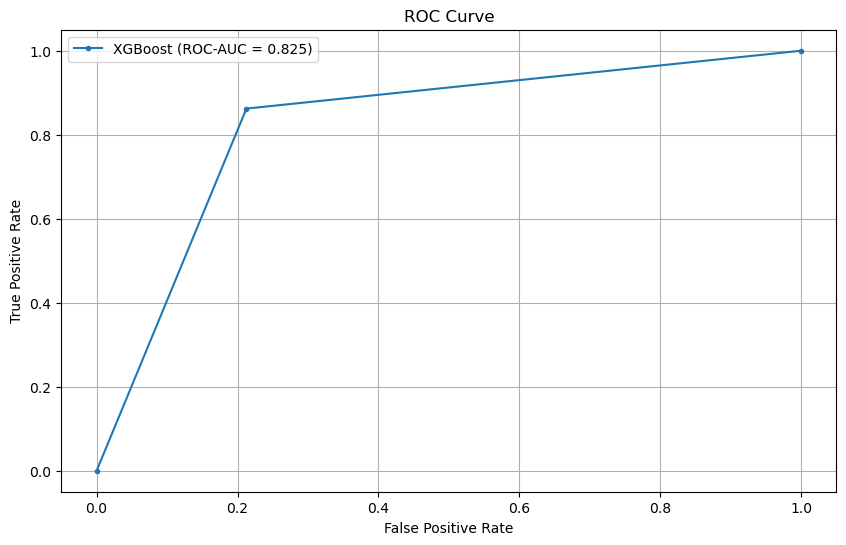

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters found: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 200}
Best cross-validated accuracy: 0.8016271835367311
Tuned Model accuracy: 0.8334928229665072
Tuned Confusion Matrix:
[[402 106]
 [ 68 469]]
Tuned Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.79      0.82       508
         1.0       0.82      0.87      0.84       537

    accuracy                           0.83      1045
   macro avg       0.84      0.83      0.83      1045
weighted avg       0.83      0.83      0.83      1045

Tuned model predictions saved to 'xgboost_tuned_predictions_for_ensemble.csv'.


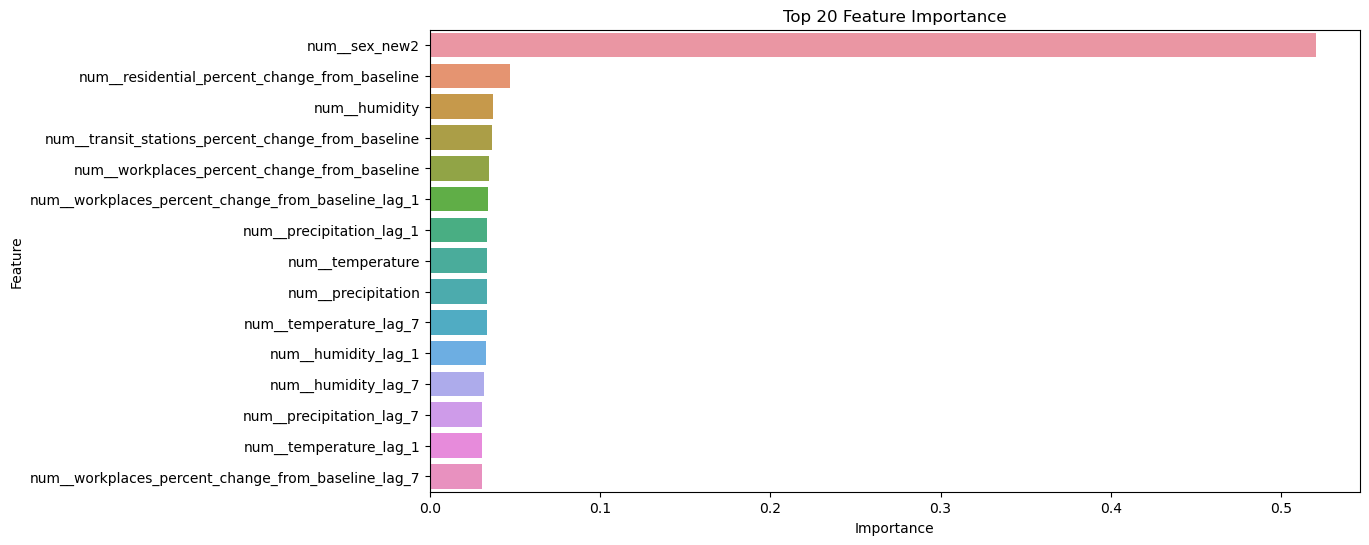

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import torch
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")

# Configurable Hyperparameters
LEARNING_RATE = 2e-5
BATCH_SIZE = 32
EPOCHS = 2
SMOTE_ENABLED = True  # To use SMOTE, set to True
np.random.seed(42)
torch.manual_seed(42)

# Load datasets
try:
    lassa_fever_data = pd.read_spss('/Users/m1/Downloads/data/VHF/Lassa Fever_Dataset_NCDC.sav')
    climatic_data = pd.read_csv('/Users/m1/Downloads/data/VHF/main_nasa_power_climatic_data_VHF 2.csv')
    mobility_data = pd.read_csv('/Users/m1/Downloads/data/VHF/2020-2022_NG_Region_Mobility_Report.csv')
except Exception as e:
    print(f"Error loading datasets: {e}")

# Select relevant columns
lassa_fever_data_relevant = lassa_fever_data[[
    'DID', 'age_grouped', 'sex_new2', 'Pregnancy', 'occupation_updated_new', 'educ_updatedcat',
    'Stateofresidence_updated', 'InitialSampleFinalLaboratoryResultPathogentest',
    'LatestSampleFinalLaboratoryResultPathogentest', 'outcome_case', 'Symptomatic',
    'fever_new', 'diarrhea_new', 'vomiting_new', 'headache_new', 'acute_hearing_loss',
    'bleeding_gums', 'nose_bleeding', 'blood_urine', 'direct_contact_probable_case',
    'date_symptom_onset2', 'date_of_outcome2', 'date_visit_or_admision2',
    'initial_sample_date2', 'DateofreportMdyyyy', 'LGA_of_residence', 'geopolitical_zone'
]].copy()

climatic_data_relevant = climatic_data[['state', 'date', 'temperature', 'humidity', 'precipitation']].copy()
mobility_data_relevant = mobility_data[['sub_region_1', 'sub_region_2', 'date', 'workplaces_percent_change_from_baseline',
                                        'residential_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline']].copy()

# Filter mobility data to keep only relevant rows and rename for consistency
mobility_data_relevant = mobility_data_relevant[mobility_data_relevant['sub_region_2'].isnull()]
lassa_fever_data_relevant.rename(columns={'Stateofresidence_updated': 'state', 'date_symptom_onset2': 'date'}, inplace=True)
mobility_data_relevant.rename(columns={'sub_region_1': 'state'}, inplace=True)

# Convert date columns to datetime format
lassa_fever_data_relevant['date'] = pd.to_datetime(lassa_fever_data_relevant['date'], errors='coerce')
climatic_data_relevant['date'] = pd.to_datetime(climatic_data_relevant['date'], format='%Y%m%d', errors='coerce')
mobility_data_relevant['date'] = pd.to_datetime(mobility_data_relevant['date'], format='%d/%m/%Y', errors='coerce')

# Handle missing or invalid values
lassa_fever_data_relevant.dropna(subset=['state'], inplace=True)  # Remove rows without state
lassa_fever_data_relevant.fillna(method='ffill', inplace=True)    # Forward fill missing values

# Merge climatic and mobility data
merged_data = lassa_fever_data_relevant.merge(climatic_data_relevant, on=['state', 'date'], how='left')
merged_data = merged_data.merge(mobility_data_relevant, on=['state', 'date'], how='left')

# Handle missing values
merged_data.drop(columns=['sub_region_2'], inplace=True)  # Drop unnecessary columns
merged_data.fillna({'Pregnancy': 'Unknown', 'direct_contact_probable_case': 'UNKNOWN', 'date_of_outcome2': 'UNKNOWN'}, inplace=True)
merged_data.dropna(subset=['initial_sample_date2'], inplace=True)

# Fill missing values with column means for numeric columns
for column in ['workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline',
               'transit_stations_percent_change_from_baseline', 'temperature', 'humidity', 'precipitation']:
    merged_data[column].fillna(merged_data[column].mean(), inplace=True)

# Create time-lagged features for climate and mobility data
lag_features = ['temperature', 'humidity', 'precipitation', 'workplaces_percent_change_from_baseline']
for feature in lag_features:
    merged_data[f'{feature}_lag_1'] = merged_data.groupby('state')[feature].shift(1)
    merged_data[f'{feature}_lag_7'] = merged_data.groupby('state')[feature].shift(7)

# Handle missing values from lagging
merged_data.fillna(method='bfill', inplace=True)

# Prepare data for model training
target = merged_data['outcome_case']
features = merged_data.drop(columns=['outcome_case', 'date', 'date_of_outcome2', 'date_visit_or_admision2',
                                     'initial_sample_date2', 'DateofreportMdyyyy'])

# Handle class imbalance and map target labels to numeric values
target = target[target.isin(['Recovered', 'Deceased'])]
features = features.loc[target.index]
target = target.map({'Recovered': 1, 'Deceased': 0})

# Convert categorical features to numeric codes
for col in features.select_dtypes(include=['category', 'object']).columns:
    features[col] = features[col].astype('category').cat.codes

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(features, target)
X_balanced = pd.DataFrame(X_balanced, columns=features.columns)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Set up the XGBoost model with preprocessing pipeline
xgb_model = XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss')
pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()),  # Scale numeric features
            ('cat', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object', 'category']).columns.tolist())  # One-hot encode categorical features
        ]
    )),
    ('classifier', xgb_model)
])

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Model accuracy: {accuracy}")
print(f"ROC-AUC Score: {roc_auc}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

# Save predictions to CSV for ensemble learning
predictions_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': y_pred
})
predictions_df.to_csv('xgboost_predictions.csv', index=False)
print("Predictions saved to 'xgboost_predictions.csv'.")

# Visualize confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Deceased', 'Recovered'], yticklabels=['Deceased', 'Recovered'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.', label=f'XGBoost (ROC-AUC = {roc_auc:.3f})')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters and cross-validated accuracy
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validated accuracy: {grid_search.best_score_}")

# Evaluate the tuned model
best_pipeline = grid_search.best_estimator_
y_pred_best = best_pipeline.predict(X_test)

print(f"Tuned Model accuracy: {accuracy_score(y_test, y_pred_best)}")
print(f"Tuned Confusion Matrix:\n{confusion_matrix(y_test, y_pred_best)}")
print(f"Tuned Classification Report:\n{classification_report(y_test, y_pred_best)}")

# Save the tuned model's predictions
predictions_df_best = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': y_pred_best
})
predictions_df_best.to_csv('xgboost_tuned_predictions_for_ensemble.csv', index=False)
print("Tuned model predictions saved to 'xgboost_tuned_predictions_for_ensemble.csv'.")

# Feature Importance Visualization
xgb_model_best = best_pipeline.named_steps['classifier']
importance = xgb_model_best.feature_importances_
feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot top 20 important features
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importance')
plt.show()


Model accuracy: 0.8258373205741627
ROC-AUC Score: 0.8247994838633997
Confusion Matrix:
[[400 108]
 [ 74 463]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.79      0.81       508
         1.0       0.81      0.86      0.84       537

    accuracy                           0.83      1045
   macro avg       0.83      0.82      0.83      1045
weighted avg       0.83      0.83      0.83      1045



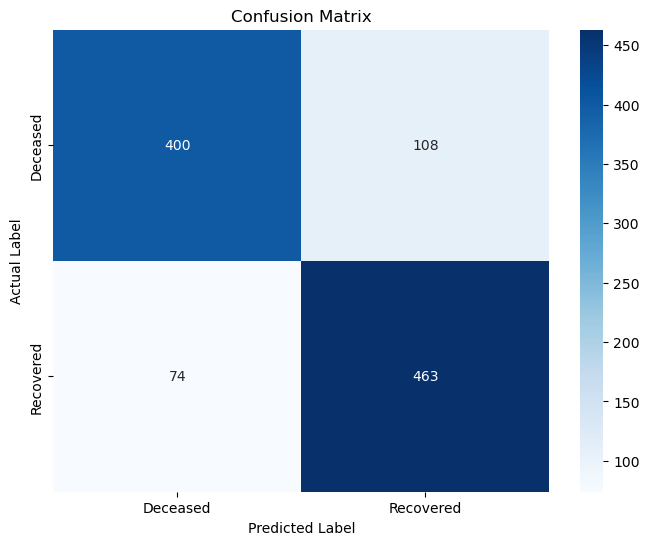

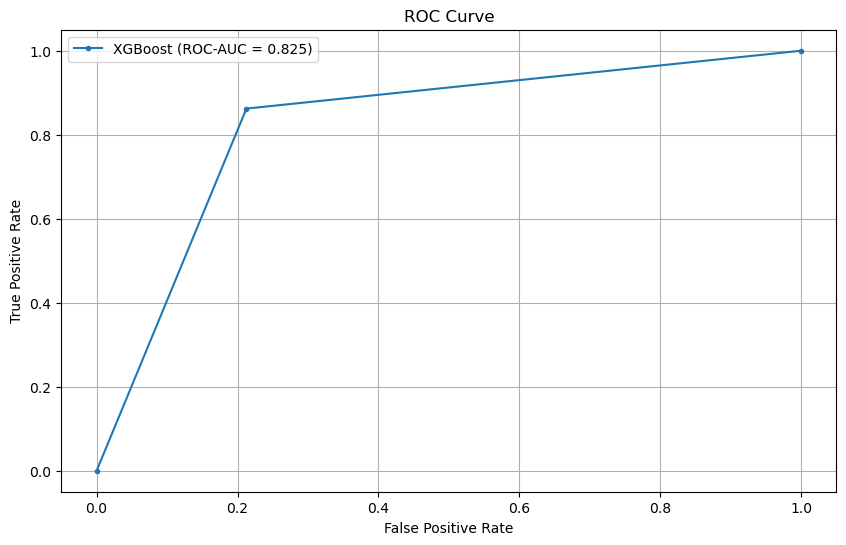

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters found: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 200}
Best cross-validated accuracy: 0.8016271835367311
Tuned Model accuracy: 0.8334928229665072
Tuned Confusion Matrix:
[[402 106]
 [ 68 469]]
Tuned Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.79      0.82       508
         1.0       0.82      0.87      0.84       537

    accuracy                           0.83      1045
   macro avg       0.84      0.83      0.83      1045
weighted avg       0.83      0.83      0.83      1045



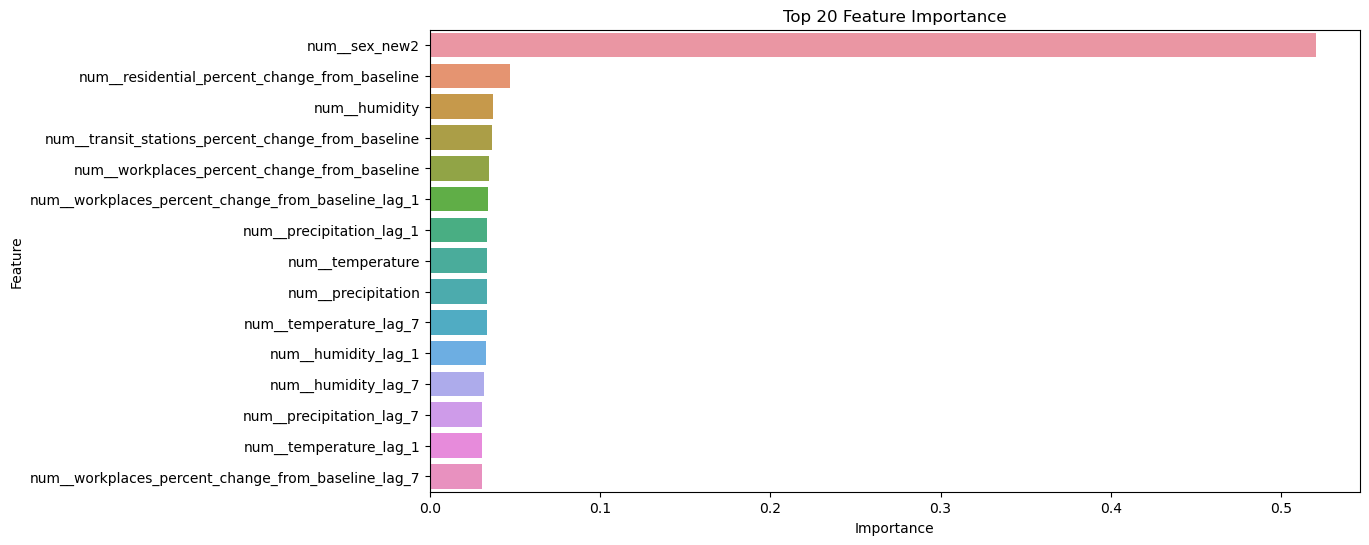

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import torch
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")

# Configurable Hyperparameters
LEARNING_RATE = 2e-5
BATCH_SIZE = 32
EPOCHS = 2
SMOTE_ENABLED = True  # To use SMOTE, set to True
np.random.seed(42)
torch.manual_seed(42)

# Load datasets
try:
    lassa_fever_data = pd.read_spss('/Users/m1/Downloads/data/VHF/Lassa Fever_Dataset_NCDC.sav')
    climatic_data = pd.read_csv('/Users/m1/Downloads/data/VHF/main_nasa_power_climatic_data_VHF 2.csv')
    mobility_data = pd.read_csv('/Users/m1/Downloads/data/VHF/2020-2022_NG_Region_Mobility_Report.csv')
except Exception as e:
    print(f"Error loading datasets: {e}")

# Select relevant columns
lassa_fever_data_relevant = lassa_fever_data[[
    'DID', 'age_grouped', 'sex_new2', 'Pregnancy', 'occupation_updated_new', 'educ_updatedcat',
    'Stateofresidence_updated', 'InitialSampleFinalLaboratoryResultPathogentest',
    'LatestSampleFinalLaboratoryResultPathogentest', 'outcome_case', 'Symptomatic',
    'fever_new', 'diarrhea_new', 'vomiting_new', 'headache_new', 'acute_hearing_loss',
    'bleeding_gums', 'nose_bleeding', 'blood_urine', 'direct_contact_probable_case',
    'date_symptom_onset2', 'date_of_outcome2', 'date_visit_or_admision2',
    'initial_sample_date2', 'DateofreportMdyyyy', 'LGA_of_residence', 'geopolitical_zone'
]].copy()

climatic_data_relevant = climatic_data[['state', 'date', 'temperature', 'humidity', 'precipitation']].copy()
mobility_data_relevant = mobility_data[['sub_region_1', 'sub_region_2', 'date', 'workplaces_percent_change_from_baseline',
                                        'residential_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline']].copy()

# Filter mobility data to keep only relevant rows and rename for consistency
mobility_data_relevant = mobility_data_relevant[mobility_data_relevant['sub_region_2'].isnull()]
lassa_fever_data_relevant.rename(columns={'Stateofresidence_updated': 'state', 'date_symptom_onset2': 'date'}, inplace=True)
mobility_data_relevant.rename(columns={'sub_region_1': 'state'}, inplace=True)

# Convert date columns to datetime format
lassa_fever_data_relevant['date'] = pd.to_datetime(lassa_fever_data_relevant['date'], errors='coerce')
climatic_data_relevant['date'] = pd.to_datetime(climatic_data_relevant['date'], format='%Y%m%d', errors='coerce')
mobility_data_relevant['date'] = pd.to_datetime(mobility_data_relevant['date'], format='%d/%m/%Y', errors='coerce')

# Handle missing or invalid values
lassa_fever_data_relevant.dropna(subset=['state'], inplace=True)  # Remove rows without state
lassa_fever_data_relevant.fillna(method='ffill', inplace=True)    # Forward fill missing values

# Merge climatic and mobility data
merged_data = lassa_fever_data_relevant.merge(climatic_data_relevant, on=['state', 'date'], how='left')
merged_data = merged_data.merge(mobility_data_relevant, on=['state', 'date'], how='left')

# Handle missing values
merged_data.drop(columns=['sub_region_2'], inplace=True)  # Drop unnecessary columns
merged_data.fillna({'Pregnancy': 'Unknown', 'direct_contact_probable_case': 'UNKNOWN', 'date_of_outcome2': 'UNKNOWN'}, inplace=True)
merged_data.dropna(subset=['initial_sample_date2'], inplace=True)

# Fill missing values with column means for numeric columns
for column in ['workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline',
               'transit_stations_percent_change_from_baseline', 'temperature', 'humidity', 'precipitation']:
    merged_data[column].fillna(merged_data[column].mean(), inplace=True)

# Create time-lagged features for climate and mobility data
lag_features = ['temperature', 'humidity', 'precipitation', 'workplaces_percent_change_from_baseline']
for feature in lag_features:
    merged_data[f'{feature}_lag_1'] = merged_data.groupby('state')[feature].shift(1)
    merged_data[f'{feature}_lag_7'] = merged_data.groupby('state')[feature].shift(7)

# Handle missing values from lagging
merged_data.fillna(method='bfill', inplace=True)

# Prepare data for model training
target = merged_data['outcome_case']
features = merged_data.drop(columns=['outcome_case', 'date', 'date_of_outcome2', 'date_visit_or_admision2',
                                     'initial_sample_date2', 'DateofreportMdyyyy'])

# Handle class imbalance and map target labels to numeric values
target = target[target.isin(['Recovered', 'Deceased'])]
features = features.loc[target.index]
target = target.map({'Recovered': 1, 'Deceased': 0})

# Convert categorical features to numeric codes
for col in features.select_dtypes(include=['category', 'object']).columns:
    features[col] = features[col].astype('category').cat.codes

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(features, target)
X_balanced = pd.DataFrame(X_balanced, columns=features.columns)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Set up the XGBoost model with preprocessing pipeline
xgb_model = XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss')
pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()),  # Scale numeric features
            ('cat', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object', 'category']).columns.tolist())  # One-hot encode categorical features
        ]
    )),
    ('classifier', xgb_model)
])

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Model accuracy: {accuracy}")
print(f"ROC-AUC Score: {roc_auc}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

# Visualize confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Deceased', 'Recovered'], yticklabels=['Deceased', 'Recovered'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.', label=f'XGBoost (ROC-AUC = {roc_auc:.3f})')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters and cross-validated accuracy
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validated accuracy: {grid_search.best_score_}")

# Evaluate the tuned model
best_pipeline = grid_search.best_estimator_
y_pred_best = best_pipeline.predict(X_test)

print(f"Tuned Model accuracy: {accuracy_score(y_test, y_pred_best)}")
print(f"Tuned Confusion Matrix:\n{confusion_matrix(y_test, y_pred_best)}")
print(f"Tuned Classification Report:\n{classification_report(y_test, y_pred_best)}")

# Feature Importance Visualization
xgb_model_best = best_pipeline.named_steps['classifier']
importance = xgb_model_best.feature_importances_
feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot top 20 important features
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importance')
plt.show()
